# Подключение к Google-диску

In [2]:
# подключение к Google диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/RSRAE_work') # смена рабочей директории

# Подготовка датасета

In [4]:
import pickle
with open("./reuters.data", 'rb') as f:
    data = pickle.load(f) # Загружаем dict с датасетом
X_test_origin = data["X"]
y_test_origin = data["y"]

data - словарь, содержащий предобработанные датасет Reuters-21578.  

Reuters-21578 содержит 90 текстовых категорий с несколькими метками. Мы рассматриваем пять самых больших классов с единичными метками и случайным образом выбираем из них 360 документов для каждого класса. Документы предварительно обрабатываются в векторы размером 26 147 путем последовательного применения преобразователя TF-IDF и Hashing vectorizer  (Rajaraman & Ullman, 2011). В каждом эксперименте нормальными данными являются документами фиксированного класса, а выбросы c × 360 случайным образом выбираются из других классов.


In [ ]:
data

{'X': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.04495253, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.13652946, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'labels': ['earn', 'acq', 'money-fx', 'crude', 'trade'],
 'y': array([2, 0, 3, ..., 0, 3, 4], dtype=int32)}

In [ ]:
print(len(data['X']))
print(len(data['y']))
print(data['labels'])
print(len([x for x in data['y'] if x == 1])) # сколько изображений в классе

1800
1800
['earn', 'acq', 'money-fx', 'crude', 'trade']
360


In [5]:
num_pure = 360 # количество нормальных экземпляром
# Cписок констант - отношение числа аномалий к нормальным данным
# cvalue_list = [0.1, 0.3, 0.5, 0.7, 0.9]
cvalue = 0.7
num_anomaly = int(num_pure * cvalue) # количество аномальных экземпляров

In [6]:
import numpy as np

inlier_class = 0 # выбрали нулевой класс как нормальный

# y_test[i] = 1 нормальный класс, 0 иначе
y_test = (np.array(y_test_origin) == inlier_class).astype(int)

X_test_normal = X_test_origin[y_test==1]
X_test_anomaly = X_test_origin[y_test==0][0:num_anomaly]
X_test = np.concatenate((X_test_normal, X_test_anomaly))
    
y_test_normal = y_test[y_test==1]
y_test_anomaly = y_test[y_test==0][0:num_anomaly]
y_test = [False] * len(X_test_normal) + [True] * num_anomaly

In [7]:
input_shape = 26147

In [ ]:
# if np.min(X_test) >= 0.:
#     activation = tf.nn.relu
# elif np.abs(np.max(X_test)) <= 1.:
#     activation = tf.nn.tanh
# else:
#     activation = tf.nn.leaky_relu

# RSRAE

In [ ]:
import numpy as np
import tensorflow as tf
print("Tensorflow version = {}".format(tf.__version__))

from tensorflow.keras import optimizers, Model, activations, Sequential, Input
from tensorflow.keras.layers import Layer, Dense, Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Reshape
from sklearn.metrics import roc_auc_score, average_precision_score

# Задаем random_seed для tensorflow и numpy
random_seed = 123
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Tensorflow version = 2.3.0


## RSR layer

In [ ]:
class RSR(Layer):
    """Robust subspace recovery layer."""
    def __init__(self, intrinsic_size ,name = "rsr", **kwargs):
        """intrinsic_size: размерность скрытого представления z""" 
        super(RSR, self).__init__(name = name, **kwargs)
        self.flatten = Flatten()
        self.intrinsic_size = intrinsic_size
        
    def build(self, input_shape):
        """Определяет веса слоя"""
        self.A = self.add_weight(name="A", shape=[int(input_shape[-1]),
                                                  self.intrinsic_size],
                                 initializer='random_normal',)
        # self.A = tf.Variable(tf.random.normal((int(input_shape[-1]), self.intrinsic_size)),
        #                     name="layer_rsr")
        
    def call(self, y):
        """Логика слоя"""
        y = self.flatten(y)
        return (tf.linalg.matmul(y, self.A), self.A)

## $l_{2}$ нормализация



In [ ]:
# Пример 
a = np.array([[1., 2., 3.], [4., 5., 6.]])
a = tf.convert_to_tensor(a, dtype=tf.float64)
print(a)
print(tf.math.l2_normalize(a, axis=0))
print(tf.math.l2_normalize(a, axis=1))

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float64)
tf.Tensor(
[[0.24253563 0.37139068 0.4472136 ]
 [0.9701425  0.92847669 0.89442719]], shape=(2, 3), dtype=float64)
tf.Tensor(
[[0.26726124 0.53452248 0.80178373]
 [0.45584231 0.56980288 0.68376346]], shape=(2, 3), dtype=float64)


Видим, что:  
$1 / \sqrt{(1^2 + 4^2)} = 0.24253562503$  
$1 / \sqrt{(1^2 + 2^2 + 3^2)} = 0.26726124191$

Так как мы нормализуем имеено вектора, соответсвующие признакам, то для матрицы размерности $N \times inputdimension$ нам надо нормализовать по axis=-1(axis=1), чтобы нормализация происходила для каждого экземпляра выборки.  

В результате $\ell_2$ нормализации признаки каждого экземпляра будут в отрезке [-1; 1]

In [ ]:
class renormalization(Layer):
    """Слой l_2 нормализации, который будет применяться к выходу RSR layer."""
    def __init__(self, name="renormalization", **kwargs):
        super(renormalization, self).__init__(name=name, **kwargs)

    def call(self, y):
        z = tf.math.l2_normalize(y, axis=-1)
        return z

## Модель автоэнкодера RSRAE
***Encoder*** представляет собой полносвязную сеть с размером (32, 64, 128).

***RSR layer*** линейно отображает выход encoder в размерность 10.

***Decoder*** представляет собой полносвязную сеть с размером (128, 64, 32, D), где D - размерность входных данных. 

***Batch normalization*** применяется к каждому слою *encoder* и *decoder*.
Перед применением *decoder* выход ***RSR layer*** - $\ell_{2,1}$ нормализуется.

In [ ]:
def autoencoder(input_dimension,
                hidden_layer_dimensions,
                activation='relu',
                bn=True, # применять BatchNormalization?
                intrinsic_size=10, # размерность скрытого представления z
                normalize=True, # применять l_2,1 нормализацию к скрытому представлению z?
                ):
    
    # Input layer
    input_data = Input(shape=(input_dimension), name='x_input')
    x = input_data

    # Encoder
    x = Dense(hidden_layer_dimensions[0], activation=activation,
              name='encoder_0')(x)
    if bn:
        x = BatchNormalization(name="encoder_bn_layer_0")(x)

    x = Dense(hidden_layer_dimensions[1], activation=activation,
              name='encoder_1')(x)
    if bn:
        x = BatchNormalization(name="encoder_bn_layer_1")(x)

    x = Dense(hidden_layer_dimensions[2], activation=activation,
              name='encoder_2')(x)
    if bn:
        x = BatchNormalization(name="encoder_bn_layer_2")(x)

    z = x

    # RSR layer
    z_rsr, A = RSR(intrinsic_size=intrinsic_size)(z)
    print(type(A))
    if normalize:
        z_tilde = renormalization()(z_rsr)
    else:
        z_tilde = z_rsr

    # Decoder
    x_tilde = z_tilde

    x_tilde = Dense(hidden_layer_dimensions[2], activation=activation,
              name='decoder_2')(x_tilde)
    if bn:
        x_tilde = BatchNormalization(name="decoder_bn_layer_2")(x_tilde)
    
    x_tilde = Dense(hidden_layer_dimensions[1], activation=activation,
              name='decoder_1')(x_tilde)
    if bn:
        x_tilde = BatchNormalization(name="decoder_bn_layer_1")(x_tilde)
    
    x_tilde = Dense(hidden_layer_dimensions[0], activation=activation,
              name='decoder_0')(x_tilde)
    if bn:
        x_tilde = BatchNormalization(name="decoder_bn_layer_0")(x_tilde)
    
    x_tilde = Dense(input_dimension, activation=activation,
              name='x_tilde_output')(x_tilde)
    
    return input_data, z, z_rsr, z_tilde, x_tilde

In [ ]:
def get_autoencoder_model(
    input_dimension,
    hidden_layer_dimensions,
    activation='relu',
    bn=True, # применять BatchNormalization?
    intrinsic_size=10, # размерность скрытого представления z
    normalize=True, # применять l_2,1 нормализацию к скрытому представлению z?
    ):
    input_data, z, z_rsr, z_tilde, x_tilde = autoencoder(input_dimension,
                                             hidden_layer_dimensions,
                                             activation,
                                             bn,
                                             intrinsic_size,
                                             normalize)
    return Model(inputs=input_data, outputs=x_tilde, name='AE')

## Задание гиперпараметров

In [ ]:
input_dimension = input_shape
hidden_layer_dimensions = [32, 64, 128] 

## Рисуем архитектуру Автоэнкодера

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
(None, 10)


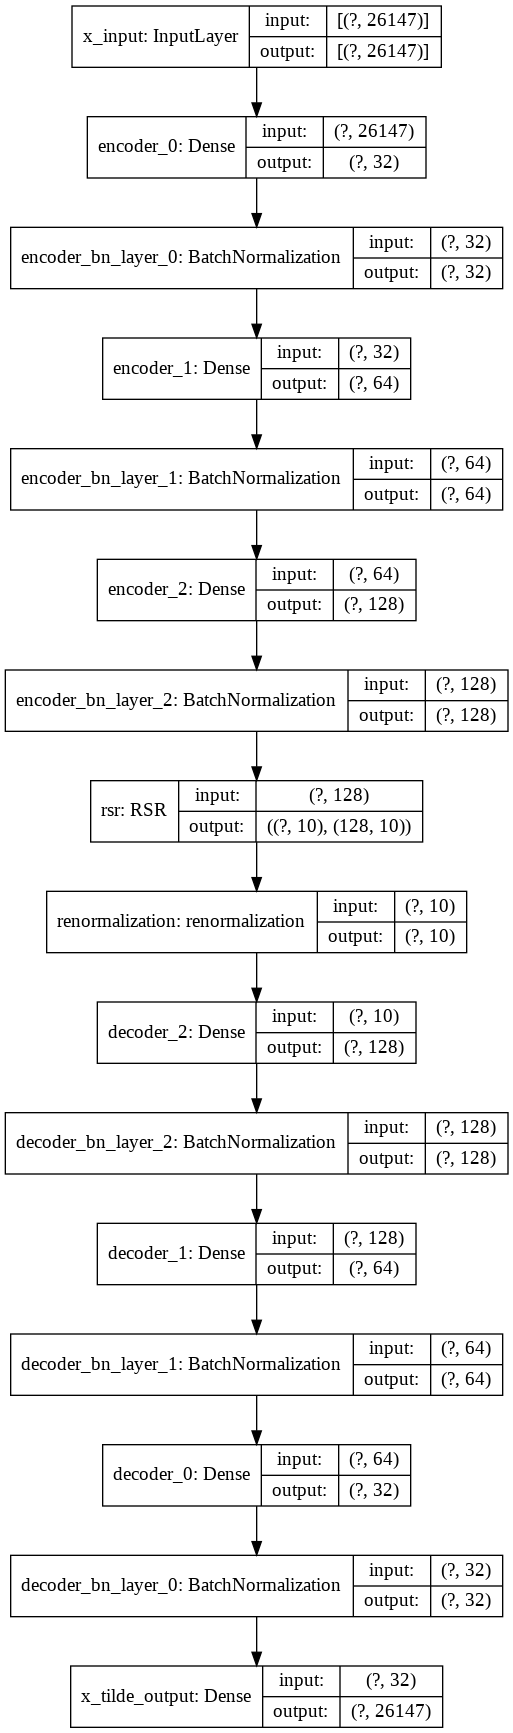

In [ ]:
from keras.utils import plot_model
autoencoder_model = get_autoencoder_model(input_dimension=input_shape,
                                          hidden_layer_dimensions=[32, 64, 128])
plot_model(autoencoder_model, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

In [ ]:
# Так можно взять веса на определенном по имени слое
autoencoder_model.get_layer('rsr').get_weights()

[array([[ 0.07020293, -0.00510678,  0.05250229, ..., -0.01855698,
         -0.00788971,  0.02096272],
        [ 0.14262943,  0.02622344, -0.01425395, ...,  0.01595254,
         -0.04768373,  0.05016956],
        [-0.03377154, -0.0814691 , -0.01141486, ...,  0.01481228,
          0.00903452, -0.01535358],
        ...,
        [ 0.05193459,  0.0512598 ,  0.07801345, ..., -0.01644316,
          0.04638854,  0.0180677 ],
        [-0.01629409,  0.04932985, -0.00814126, ...,  0.07287434,
          0.01898942, -0.00117054],
        [-0.04878144,  0.01758119, -0.0379256 , ..., -0.04490825,
         -0.05983667,  0.00798384]])]

In [ ]:
autoencoder_model.get_layer['rsr']

TypeError: ignored

## Функции ошибок


### Функция потери реконструкции автоэнкодера -  $L^p_{AE}(\xi, A, \cal{D})$ $=$ $\sum\limits_{t=1}^N\|x^{(t)} - \bar{x}^{(t)}\|^p_2$
$p = 1$

In [ ]:
# Пример tf.reduce_mean
x = tf.constant([[1., 1.], [2., 2.]])
print(tf.reduce_mean(x))
y = tf.constant([[1., 2.], [3., 4.]])
print(tf.reduce_mean(y))

tf.Tensor(1.5, shape=(), dtype=float32)
tf.Tensor(2.5, shape=(), dtype=float32)


In [ ]:
def reconstruction_loss(x, x_tilde, loss_norm_type):
        x = tf.reshape(x, shape=[x.shape[0], -1])
        x_tilde = tf.reshape(x_tilde, shape=[x_tilde.shape[0], -1])

        # axis=1 для tf.norm => вычисление вдоль оси признаков
        # tf.math.reduce_mean без параметров - mean от элементов матрицы
        if loss_norm_type in ['MSE', 'mse', 'Frob', 'F']:
            return tf.math.reduce_mean(tf.math.square(tf.norm(x-x_tilde, 
                                                              ord=2, axis=1)))
        elif loss_norm_type in ['L1', 'l1']:
            return tf.math.reduce_mean(tf.norm(x-x_tilde, ord=1, axis=1))
        elif loss_norm_type in ['LAD', 'lad', 'L21', 'l21', 'L2', 'l2']:
            return tf.math.reduce_mean(tf.norm(x-x_tilde, ord=2, axis=1))
        else:
            raise Exception("Norm type error!")

### Функция потери RSR layer -  $L_{RSR_1}(z, A)$ $=$ $\sum\limits_{t=1}^N\|z^{(t)} - A^tAz^{(t)}\|^q_2$ где $z_{rsr} = Az^{(t)}$
$q = 1$

In [ ]:
def rsr1_loss(z, z_rsr, A, loss_norm_type):
    z_rsr = tf.matmul(z_rsr, tf.transpose(A))

    if loss_norm_type in ['MSE', 'mse', 'Frob', 'F']:
        return tf.math.reduce_mean(tf.math.square(tf.norm(z-z.rsr, ord=2, 
                                                          axis=1)))
    elif loss_norm_type in ['L1', 'l1']:
        return tf.math.reduce_mean(tf.norm(z-z.rsr, ord=1, axis=1))
    elif loss_norm_type in ['LAD', 'lad', 'L21', 'l21', 'L2', 'l2']:
        return tf.math.reduce_mean(tf.norm(z-z.rsr, ord=2, axis=1))
    else:
        raise Exception("Norm type error!")  

### Функция потери RSR layer -  $L_{RSR_2}(A)$ $=$ $\|AA^T - I_d\|_F$

In [ ]:
def rsr2_loss(A, intrinsic_size):
    return tf.math.reduce_mean(tf.math.square(tf.linalg.matmul(
        tf.transpose(A), A) - tf.eye(intrinsic_size, dtype=tf.float64)))

In [ ]:
def train_step(x):
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2, tf.GradientTape() as tape3:
            input_data, z, z_rsr, z_tilde, x_tilde = autoencoder(input_dimension,
                                                                 hidden_layer_dimensions)
            y, y_rsr, z, x_tilde = self.call(x, train)
            z = tf.keras.layers.Flatten()(z)
            loss = self.reconstruction_error(x, x_tilde)
            proj_error = self.proj_error()
            pca_error = self.pca_error(y, y_rsr)
        
        gradients1 = tape1.gradient(loss ,self.trainable_weights)
        self.optimizer1.apply_gradients(zip(gradients1, self.trainable_weights))
        gradients2 = tape2.gradient(pca_error, self.A)
        self.optimizer2.apply_gradients(zip([gradients2], [self.A]))
        gradients3 = tape3.gradient(proj_error, self.A)
        self.optimizer3.apply_gradients(zip([gradients3], [self.A]))
        
        return loss

# Через класс

## Импорт необходимых библиотек

In [7]:
import numpy as np
import tensorflow as tf
print("Tensorflow version = {}".format(tf.__version__)) # текущая версия tf

from tensorflow.keras import Model, optimizers, metrics
from tensorflow.keras.layers import Layer, Flatten, Dense, BatchNormalization

# from tensorflow.keras import activations, Sequential, Input
# from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
# from sklearn.metrics import roc_auc_score, average_precision_score

# Задаем random_seed для tensorflow и numpy
random_seed = 123
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# Sets the default float type
tf.keras.backend.set_floatx('float64')

# Set random seed
tf.random.set_seed(123)
np.random.seed(123)

Tensorflow version = 2.3.0


## Класс для ***RSR layer***

In [8]:
class RSR(Layer):
    """
    Robust Subspace Recovery (RSR) layer.
    Робастный слой, восстанавливающий подпространство. Задача данного слоя - отобразить
    закодированные энкодером данные в подпростраство так, чтобы после их обратного
    отображения декодером дивергенция между экземпляром исходных данных и его образом,
    полученным от автоэнкодера была незначительной для нормального экземпляра и была
    большой для аномального экземпляра. 

    # Example
    ```
        z_rsr, A = RSR(intrinsic_size=10)(z)
    ```
    # Arguments
        intrinsic_size: размерность z_rsr.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)` after encoding.
    # Output shape
        2D tensor with shape: `(n_samples, intrinsic_size)`.
    """

    def __init__(self, intrinsic_size: int, name="RSR_layer", **kwargs):
        super(RSR, self).__init__(name=name, **kwargs)
        # Если присваивать экземпляр слоя, как атрибут другого слоя, то хорошей
        # практикой делать создавать такие подслои в __init__ (поскольку подслои обычно
        # имеют метод build, они будут собраны, когда будет собран внешний слой). 
        self.flatten = Flatten()
        self.intrinsic_size = intrinsic_size
        
    def build(self, input_shape):
        """Определяет веса слоя, а именно задает матрицу A."""
        self.A = self.add_weight(name="A",
                                 shape=[int(input_shape[-1]), self.intrinsic_size],
                                 initializer='random_normal',
                                 trainable=True,)
        
    def call(self, z):
        """
        Логика слоя. Умножение выхода энкодера - вектора z на матрицу A.
        Возвращает отображенный z_rsr и матрицу A, которая потребуется далее.
        """
        z = self.flatten(z)
        z_rsr = tf.linalg.matmul(z, self.A) 
        return z_rsr

    # Опционально, пользовательский слой может быть сериализован реализацией метода 
    # get_config и метода класса (@classmethod) from_config.
    def get_config(self):
        config = super(Layer, self).get_config()
        config.update({'intrinsic_size': self.intrinsic_size})
        return config

    # На самом деле нет необходимости определять `from_config` здесь, поскольку 
    # возвращение `cls(**config)` - поведение по умолчанию.
    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Слой для $\ell_2$ нормализации данных, полученных после применения ***RSR layer***

In [9]:
class L2Normalization(Layer):
    """Слой для l_2 нормализации, который будет применяться к выходу RSR layer."""
    
    def __init__(self, name="L2Normalization", **kwargs):
        super(L2Normalization, self).__init__(name=name, **kwargs)

    def call(self, z_rsr):
        """
        Выполняет l_2 нормализацию векторов, полученных после применения RSR layer
        вдоль оси, соответсвующей числу признаков. То есть производится нормализация
        каждого экземпляра выборки, в результате которой признаки экземпляров будут
        находиться в отрезке [-1; 1].
        """
        z_tilde = tf.math.l2_normalize(z_rsr, axis=-1)
        return z_tilde

    # Опционально, пользовательский слой может быть сериализован реализацией метода 
    # get_config и метода класса (@classmethod) from_config.
    def get_config(self):
        config = super(Layer, self).get_config()
        return config

    # На самом деле нет необходимости определять `from_config` здесь, поскольку 
    # возвращение `cls(**config)` - поведение по умолчанию.
    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Класс для ***Encoder***

In [10]:
class Encoder(Layer):
    """
    Класс для encoder модели RSRAE. Отображает исходные данные input_data в вектор z,
    кодирующий исходные данные.
    """

    def __init__(self,
                 hidden_layer_dimensions,
                 activation,
                 flag_bn=True, 
                 name="Encoder",
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.hidden_layer_dimensions = hidden_layer_dimensions
        self.activation = activation
        self.flag_bn = flag_bn
        self.dense0 = Dense(hidden_layer_dimensions[0], activation=activation,
                            name='encoder_0')
        self.dense1 = Dense(hidden_layer_dimensions[1], activation=activation,
                            name='encoder_1')
        self.dense2 = Dense(hidden_layer_dimensions[2], activation=activation,
                            name='encoder_2')
        if flag_bn:
            self.batch_normalization0 = BatchNormalization(name="encoder_bn_layer_0")
            self.batch_normalization1 = BatchNormalization(name="encoder_bn_layer_1")
            self.batch_normalization2 = BatchNormalization(name="encoder_bn_layer_2")

    def call(self, inputs):
        """Отображние исходных данных x -> в закодированный вектор z."""
        x = inputs
        x = self.dense0(x)
        if self.flag_bn:
            x = self.batch_normalization0(x)
        x = self.dense1(x)
        if self.flag_bn:
            x = self.batch_normalization1(x)
        x = self.dense2(x)
        if self.flag_bn:
            x = self.batch_normalization2(x)
        z = x
        return z
    
    # Опционально, пользовательский слой может быть сериализован реализацией метода 
    # get_config и метода класса (@classmethod) from_config.
    def get_config(self):
        config = super(Layer, self).get_config()
        config.update({'hidden_layer_dimensions': self.hidden_layer_dimensions})
        config.update({'activation': self.activation})
        config.update({'flag_bn': self.flag_bn})
        return config

    # На самом деле нет необходимости определять `from_config` здесь, поскольку 
    # возвращение `cls(**config)` - поведение по умолчанию.
    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Класс для ***Decoder***

In [11]:
class Decoder(Layer):
    """
    Класс для decoder модели RSRAE. Отображает вектор z_rsr, полученный в результате
    кодирования исходных данных в вектор z, и последующим отображением вектора z при
    помощи RSR layer (x -> z -> z_rsr), обратно в пространство исходных данных 
    (z_rsr -> x_tilde).
    """

    def __init__(self,
                 inputs_dim,
                 hidden_layer_dimensions,
                 activation,
                 flag_bn=True, 
                 name="Decoder",
                 **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.hidden_layer_dimensions = hidden_layer_dimensions
        self.activation = activation
        self.flag_bn = flag_bn
        self.dense2 = Dense(hidden_layer_dimensions[2], activation=activation,
                            name='decoder_2')
        self.dense1 = Dense(hidden_layer_dimensions[1], activation=activation,
                            name='decoder_1')
        self.dense0 = Dense(hidden_layer_dimensions[0], activation=activation,
                            name='decoder_0')
        self.dense_output = Dense(inputs_dim, activation=activation,
                            name='decoder_output')
        if flag_bn:
            self.batch_normalization2 = BatchNormalization(name="decoder_bn_layer_2")
            self.batch_normalization1 = BatchNormalization(name="decoder_bn_layer_1")
            self.batch_normalization0 = BatchNormalization(name="decoder_bn_layer_0")
    def call(self, inputs):
        """
        Отображние z_rsr -> x_tilde, где x_tilde - вектор, лежащий в пространстве
        исходных даных.
        """
        z_rsr = inputs
        z_rsr = self.dense2(z_rsr)
        if self.flag_bn:
            z_rsr = self.batch_normalization2(z_rsr)
        z_rsr = self.dense1(z_rsr)
        if self.flag_bn:
            z_rsr = self.batch_normalization1(z_rsr)
        z_rsr = self.dense0(z_rsr)
        if self.flag_bn:
            z_rsr = self.batch_normalization0(z_rsr)
        x_tilde = self.dense_output(z_rsr)
        return x_tilde
    
    # Опционально, пользовательский слой может быть сериализован реализацией метода 
    # get_config и метода класса (@classmethod) from_config.
    def get_config(self):
        config = super(Layer, self).get_config()
        config.update({'hidden_layer_dimensions': self.hidden_layer_dimensions})
        config.update({'activation': self.activation})
        config.update({'flag_bn': self.flag_bn})
        return config

    # На самом деле нет необходимости определять `from_config` здесь, поскольку 
    # возвращение `cls(**config)` - поведение по умолчанию.
    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Класс для модели ***Robust Subspace Recovery AutoEncoder (RSRAE)***

In [12]:
class RSRAE(Model):
    """
    Нейросетевая модель-автоэнкодер для обнаружения аномалий с робастным слоем,
    восстанавливающим подпространство (RSR layer между encoder и decoder).
    Комбинируем encoder + RSR layer + decoder в end-to-end модель.
    """

    def __init__(self,
                 inputs_dim, # размерность вектора признаков
                 hidden_layer_dimensions,
                 intrinsic_size, # разерность z_rsr после RSR layer
                 activation,
                 flag_bn=True,
                 flag_normalize=True,
                 learning_rate=1e-3,
                 ae_loss_norm_type='MSE',
                 rsr_loss_norm_type='MSE',
                 name='RSRAE',
                 **kwargs):
        super(RSRAE, self).__init__(name=name, **kwargs)
        self.inputs_dim = inputs_dim
        self.hidden_layer_dimensions = hidden_layer_dimensions
        self.intrinsic_size = intrinsic_size
        self.activation = activation
        self.flag_bn = flag_bn
        self.flag_normalize = flag_normalize
        self.learning_rate = learning_rate
        self.ae_loss_norm_type = ae_loss_norm_type
        self.rsr_loss_norm_type = rsr_loss_norm_type
        # Для вычисления среднего loss по loss всех батчей в эпохе
        self.loss_tracker = metrics.Mean(name="loss")

        # Создание экземпляров оптимизаторов
        self.optimizer_ae = optimizers.Adam(learning_rate=learning_rate)
        self.optimizer_rsr1 = optimizers.Adam(learning_rate=10 * learning_rate)
        self.optimizer_rsr2 = optimizers.Adam(learning_rate=10 * learning_rate)

        # Слои
        self.encoder = Encoder(hidden_layer_dimensions=hidden_layer_dimensions,
                               activation=activation,
                               flag_bn=flag_bn)
        self.rsr = RSR(intrinsic_size=intrinsic_size)
        if flag_normalize:
            self.l2normalization = L2Normalization()
        self.decoder = Decoder(inputs_dim=inputs_dim,
                               hidden_layer_dimensions=hidden_layer_dimensions,
                               activation=activation,
                               flag_bn=flag_bn)
        
    def call(self, inputs):
        z = self.encoder(inputs)
        z_rsr = self.rsr(z)
        if self.flag_normalize:
            z_rsr = self.l2normalization(z_rsr)
        x_tilde = self.decoder(z_rsr)
        return z, z_rsr, x_tilde

    def ae_loss(self, x, x_tilde):
        """Функция потерь реконструкции автоэнкодера - L_AE."""

        x = tf.reshape(x, (tf.shape(x)[0], -1))
        x_tilde = tf.reshape(x_tilde, (tf.shape(x_tilde)[0], -1))

        # axis=1 для tf.norm => вычисление вдоль оси признаков
        # tf.math.reduce_mean без параметров - mean от элементов матрицы
        if self.ae_loss_norm_type in ['MSE', 'mse', 'Frob', 'F']:
            return tf.math.reduce_mean(tf.math.square(tf.norm(x-x_tilde, 
                                                              ord=2, axis=1)))
        elif self.ae_loss_norm_type in ['L1', 'l1']:
            return tf.math.reduce_mean(tf.norm(x-x_tilde, ord=1, axis=1))
        elif self.ae_loss_norm_type in ['LAD', 'lad', 'L21', 'l21', 'L2', 'l2']:
            return tf.math.reduce_mean(tf.norm(x-x_tilde, ord=2, axis=1))
        else:
            raise Exception("Norm type error!")
    
    def rsr1_loss(self, z, z_rsr):
        """Функция потери для RSR layer - L_RSR1."""
        z_rsr = tf.matmul(z_rsr, tf.transpose(self.rsr.A))

        if self.rsr_loss_norm_type in ['MSE', 'mse', 'Frob', 'F']:
            return tf.math.reduce_mean(tf.math.square(tf.norm(z-z_rsr, ord=2, 
                                                            axis=1)))
        elif self.rsr_loss_norm_type in ['L1', 'l1']:
            return tf.math.reduce_mean(tf.norm(z-z_rsr, ord=1, axis=1))
        elif self.rsr_loss_norm_type in ['LAD', 'lad', 'L21', 'l21', 'L2', 'l2']:
            return tf.math.reduce_mean(tf.norm(z-z_rsr, ord=2, axis=1))
        else:
            raise Exception("Norm type error!")
    
    def rsr2_loss(self):
        """Функция потери для RSR layer - L_RSR2."""
        A = self.rsr.A
        A_T = tf.transpose(A)
        I = tf.eye(self.intrinsic_size, dtype=tf.float64)
        return tf.math.reduce_mean(tf.math.square(tf.linalg.matmul(A_T, A) - I))
        
    def gradients(model, inputs, targets):
        with tf.GradientTape() as tape:
            loss_value = loss_fn(model, inputs, targets)
        return tape.gradient(loss_value, model.trainable_variables)
    
    @tf.function()
    def train_step(self, x):
        """
        Override the method. Будет вызываться при 'model.fit()'.
        Один шаг обучения, на котором вычисляются функции потерь для автоэнкодера и
        RSR layer, и в соотвествии с ними обновляются значения обучаемых переменных - 
        весов нейросети и матрицы A соответсвенно. Будет вызываться от одного батча.
        Заметим, что в этом методе мы используем пользовательские оптимизаторы и функции
        потерь, поэтому перед тренировкой метод compile вызывать не придется.
        """

        # tf.GradientTape() - записывает операции для автоматического дифференцирования

        # По умолчанию persistent=False и удерживаемые GradientTape, высвобождаются,
        # как только вызывается метод GradientTape.gradient(). Чтобы вычислить несколько
        # градиентов за одно вычисление, требуется задать persistent=true. Это позволяет
        # многократно вызывать метод gradient(), тогда требуется самостоятельно
        # освободить ресурсы с помощью 'del tape'.

        # watch_accessed_variables=True => автоматическое отслеживание всех обучаемых
        # переменные, к которым осуществляется доступ. Так градиенты могут быть
        # запрошены c любого вычисленного результата в tape.
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:
            # Здесь требуется запустить прямой проход нейросети. Операции применяемые
            # при проходе к входных данным будут записаны на GradientTape. 
            z, z_rsr, x_tilde = self.call(x) # прямой проход RSRAE
            z = tf.keras.layers.Flatten()(z) # вроде для текстовых данных необязательно
            # Вычисляем значения функций потерь для этого прохода
            loss_ae = self.ae_loss(x, x_tilde)
            loss_rsr1 = self.rsr1_loss(z, z_rsr)
            loss_rsr2 = self.rsr2_loss()
  
        # Метод gradient вычисляет градиенты обучаемых параметров(весов) для минимизации
        # функции потерь, используя операции, записанные в контексте этого tape.
        gradients_ae = tape.gradient(loss_ae, self.trainable_weights)
        gradients_rsr1 = tape.gradient(loss_rsr1, self.rsr.A)
        gradients_rsr2 = tape.gradient(loss_rsr2, self.rsr.A)

        # Обновим значения обучаемых переменных - градиентный шаг чтобы min loss.
        self.optimizer_ae.apply_gradients(grads_and_vars=
                                          zip(gradients_ae, self.trainable_weights))
        self.optimizer_rsr1.apply_gradients(grads_and_vars=
                                            zip([gradients_rsr1], [self.rsr.A]))
        self.optimizer_rsr2.apply_gradients(grads_and_vars=
                                            zip([gradients_rsr2], [self.rsr.A]))
        
        self.loss_tracker.update_state(loss_ae) # обновляем средний loss по батчам

        del tape # persistent=True => требуется самостоятельно освободить ресурсы
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        """
        В пару к train_step. Сбрасывает метрики (`reset_states()`) в начале каждой
        эпохи обучения с помощью 'fit()'. Без этого свойства 'result()' будет 
        возвращать среднее значение с начала обучения.
        """
        return [self.loss_tracker]

## Функция для вычисления ***cosine_similarity***:

In [40]:
model_rsrae = RSRAE(inputs_dim=X_test.shape[-1],
                    hidden_layer_dimensions=[32, 64, 128],
                    intrinsic_size=10,
                    activation='relu',
                    learning_rate=25e-5)
model_rsrae.compile()
model_rsrae.fit(x=X_test,
                batch_size=128,
                epochs=200)

Epoch 1/200
5/5 [==============================] - 0s 33ms/step - loss: 1.0291
Epoch 2/200
5/5 [==============================] - 0s 26ms/step - loss: 0.9909
Epoch 3/200
5/5 [==============================] - 0s 22ms/step - loss: 0.9862
Epoch 4/200
5/5 [==============================] - 0s 19ms/step - loss: 0.9822
Epoch 5/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9785
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9750
Epoch 7/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9716
Epoch 8/200
5/5 [==============================] - 0s 21ms/step - loss: 0.9681
Epoch 9/200
5/5 [==============================] - 0s 22ms/step - loss: 0.9647
Epoch 10/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9612
Epoch 11/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9578
Epoch 12/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9545
Epoch 13/200
5/5 [==============================]

In [41]:
X_predict = model_rsrae.predict(X_test)[2]
flat_output = np.reshape(X_predict, (np.shape(X_test)[0], -1))
flat_input = np.reshape(X_predict, (np.shape(X_test)[0], -1))
cosine_similarity = np.sum(flat_output * flat_input, -1) / (np.linalg.norm(flat_output, axis=-1) + 0.000001) / (np.linalg.norm(flat_input, axis=-1) + 0.000001)
print(X_predict)

[[0.00278981 0.         0.         ... 0.         0.         0.        ]
 [0.         0.27974132 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [90]:
from sklearn.metrics.pairwise import cosine_similarity as cs

sklearn_cosine_similarity = cs(flat_output, flat_input)
print(sklearn_cosine_similarity)

[[1.         0.05771148 0.18450001 ... 0.19555937 0.25960004 0.34856845]
 [0.05771148 1.         0.05621883 ... 0.15201898 0.02540892 0.02117112]
 [0.18450001 0.05621883 1.         ... 0.28010548 0.21703197 0.2137534 ]
 ...
 [0.19555937 0.15201898 0.28010548 ... 1.         0.20943058 0.25319157]
 [0.25960004 0.02540892 0.21703197 ... 0.20943058 1.         0.8800537 ]
 [0.34856845 0.02117112 0.2137534  ... 0.25319157 0.8800537  1.        ]]


In [85]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(gamma='auto').fit(X_predict)
SVM_predict = clf.predict(X_predict)


In [86]:
print(SVM_predict)

[-1 -1  1 -1  1  1 -1 -1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1
 -1  1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1
  1  1  1 -1 -1 -1 -1  1 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1
 -1  1  1  1 -1 -1  1  1  1 -1 -1  1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1
  1 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1  1  1 -1  1
  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1  1
  1 -1 -1 -1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1
  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1
 -1  1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1  1  1  1  1 -1  1 -1
 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1 -1 -1 -1
 -1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1  1  1  1 -1 -1
 -1  1 -1 -1  1 -1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1
 -1  1 -1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1  1  1 -1

In [87]:
positive = 0
negative = 0

for y_true, y_predict in zip(y_test, SVM_predict):
    if y_true == (y_predict == -1):
        positive += 1
    else:
        negative += 1

print("positive = {}".format(positive))
print("negative = {}".format(negative))
print("FPR = {}".format(positive / (positive + negative)))

positive = 169
negative = 227
FPR = 0.42676767676767674


In [42]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve


auc = roc_auc_score(y_test, -cosine_similarity)
ap = average_precision_score(y_test, -cosine_similarity)
precision_recall_curve(y_test, -cosine_similarity)
# precision, recall, thresholds = precision_recall_curve(y_test, -cosine_similarity)
                                    
print("auc = ", auc)
print("ap = ", ap)
# print("P = {}, R = {}, T = {}".format(precision, recall, thresholds))

auc =  0.8151173085436032
ap =  0.7483753831137188


In [55]:
model_rsrae.summary()

ValueError: ignored

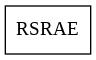

In [53]:
from keras.utils import plot_model
plot_model(model_rsrae, to_file='model_rsrae.png', show_shapes=True)
from IPython.display import Image
Image(filename='model_rsrae.png')

In [13]:
X_test.shape

(396, 26147)

In [46]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")


class CustomModel(keras.Model):
    def train_step(self, data):
        
        x, y = data
        print('x.shape: ', x.shape)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = keras.losses.mean_squared_error(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        mae_metric.update_state(y, y_pred)
        return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, mae_metric]


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)

# We don't passs a loss or metrics here.
model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, batch_size=100, epochs=5)

Epoch 1/5
x.shape:  (100, 32)
x.shape:  (100, 32)
10/10 [==============================] - 0s 1ms/step - loss: 0.7247 - mae: 0.7353
Epoch 2/5
10/10 [==============================] - 0s 1ms/step - loss: 0.5153 - mae: 0.5967
Epoch 3/5
10/10 [==============================] - 0s 1ms/step - loss: 0.3685 - mae: 0.4916
Epoch 4/5
10/10 [==============================] - 0s 1ms/step - loss: 0.2803 - mae: 0.4246
Epoch 5/5
10/10 [==============================] - 0s 1ms/step - loss: 0.2354 - mae: 0.3899


In [ ]:
m = tf.keras.metrics.Mean()
m.update_state([1, 3, 5, 7])
m.result().numpy()
m.update_state([9])
m.result().numpy()

5.0